In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=c6e4ac4da3de2045958661983fa926571d01b8eb019e6410624775ca0356b1ab
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession

In [5]:
# Create a SparkSession
spark = SparkSession.builder.appName("Urban_Air_Quality_Analysis").getOrCreate()

In [6]:
# Read CSV file into DataFrame
csv_file_path = "/content/drive/MyDrive/Urban Air Quality and Health Impact Dataset.csv"
df = spark.read.csv(csv_file_path, header=True)

In [7]:
df.head(5)

[Row(datetime='2024-09-07', datetimeEpoch='1725692400.0', tempmax='106.1', tempmin='91.0', temp='98.5', feelslikemax='104.0', feelslikemin='88.1', feelslike='95.9', dew='51.5', humidity='21.0', precip='0.0', precipprob='5.0', precipcover='0.0', preciptype=None, snow='0.0', snowdepth='0.0', windgust='26.3', windspeed='13.7', winddir='107.3', pressure='1009.2', cloudcover='25.0', visibility='10.0', solarradiation='261.4', solarenergy='22.5', uvindex='9.0', severerisk='10.0', sunrise='06:06:50', sunriseEpoch='1725714410.0', sunset='18:44:53', sunsetEpoch='1725759893.0', moonphase='0.16', conditions='Partially cloudy', description='Partly cloudy throughout the day.', icon='partly-cloudy-day', stations="['KSDL', 'KDVT', 'AZM15', 'KPHX']", source='comb', City='Phoenix', Temp_Range='15.099999999999994', Heat_Index='95.91870310999995', Severity_Score='4.43', Condition_Code=None, Month='9.0', Season='Fall', Day_of_Week='Saturday', Is_Weekend='True', Health_Risk_Score='10.522170310999996'),
 Row

In [8]:
# PySpark imports for handling data, machine learning, and preprocessing
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StandardScaler, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [9]:
import pandas as pd

In [10]:
def summary(df):
    # Data shape
    num_rows = df.count()
    num_cols = len(df.columns)
    print(f"Data shape: {num_rows} rows, {num_cols} columns")

    # Missing values and duplicates
    missing_vals = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
    total_duplicates = num_rows - df.dropDuplicates().count()

    # Unique values
    unique_vals = df.select([F.countDistinct(c).alias(c) for c in df.columns])

    # Basic statistics using describe
    desc = df.describe().toPandas().set_index('summary').transpose()

    # Show first few values
    first_values = df.limit(3).toPandas()

    # Display summary (convert to Pandas for easy manipulation)
    summary_df = pd.DataFrame({
        'Data Type': [dtype for _, dtype in df.dtypes],
        'Missing#': missing_vals.collect()[0],
        'Uniques': unique_vals.collect()[0],
        'Count': [df.filter(F.col(c).isNotNull()).count() for c in df.columns],
        'Min': desc['min'].values if 'min' in desc else None,
        'Max': desc['max'].values if 'max' in desc else None,
        'Average': desc['mean'].values if 'mean' in desc else None,
        'Standard Deviation': desc['stddev'].values if 'stddev' in desc else None,
        'First Value': first_values.iloc[0].values,
        'Second Value': first_values.iloc[1].values,
        'Third Value': first_values.iloc[2].values
    })

    # Print or display the summary table
    print(summary_df)

In [11]:
# Run the summary function on the PySpark DataFrame
summary(df)

Data shape: 1000 rows, 46 columns
   Data Type  Missing#  Uniques  Count  \
0     string         0       15   1000   
1     string         0      895   1000   
2     string         0      951   1000   
3     string         0      948   1000   
4     string         0      970   1000   
5     string         0      962   1000   
6     string         0      951   1000   
7     string         0      971   1000   
8     string         0      972   1000   
9     string         0      978   1000   
10    string         0      885   1000   
11    string         0      890   1000   
12    string         0      857   1000   
13    string       622        1    378   
14    string         0        1   1000   
15    string        71        1    929   
16    string         0      914   1000   
17    string         0      891   1000   
18    string         0      996   1000   
19    string         0      952   1000   
20    string         0      982   1000   
21    string         0      868   1000   


In [12]:
# Drop specified columns in PySpark
columns_to_drop = ["preciptype", "snow", "snowdepth", "Condition_Code", "Month", "Season", "stations"]

# Create a new DataFrame with the specified columns removed
df_cleaned = df.drop(*columns_to_drop)

# Show the updated DataFrame to confirm
df_cleaned.show(5)


+----------+-------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+--------+---------+-------+--------+----------+----------+--------------+-----------+-------+----------+--------+------------+--------+------------+---------+----------------+--------------------+-----------------+------+-------+------------------+-----------------+------------------+-----------+----------+------------------+
|  datetime|datetimeEpoch|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|windgust|windspeed|winddir|pressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk| sunrise|sunriseEpoch|  sunset| sunsetEpoch|moonphase|      conditions|         description|             icon|source|   City|        Temp_Range|       Heat_Index|    Severity_Score|Day_of_Week|Is_Weekend| Health_Risk_Score|
+----------+-------------+-------+-------+----+------------+------------+---------+----+--

In [13]:
# Count total null values across all columns in df_cleaned
null_counts = df_cleaned.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns])

# Sum the null counts across all columns
total_nulls = null_counts.select([F.sum(F.col(c)).alias(c) for c in null_counts.columns])
total_nulls_sum = total_nulls.select(F.expr(" + ".join(null_counts.columns)).alias("total_nulls"))

# Show the total number of null values
total_nulls_sum.show()

+-----------+
|total_nulls|
+-----------+
|          0|
+-----------+



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df_cleaned.select('Health_Risk_Score').toPandas()



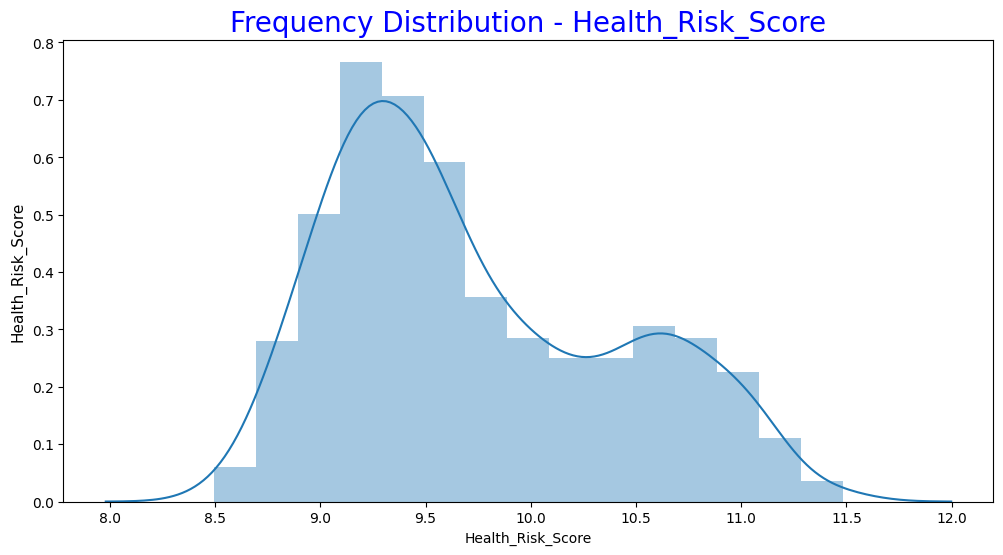

In [15]:
# Histogram - 'Health_Risk_Score'
ax = sns.distplot(df_pandas['Health_Risk_Score'])
ax.figure.set_size_inches(12, 6)
ax.set_title('Frequency Distribution - Health_Risk_Score', fontsize=20, color = "blue")
ax.set_ylabel('Health_Risk_Score', fontsize=11)
plt.show()

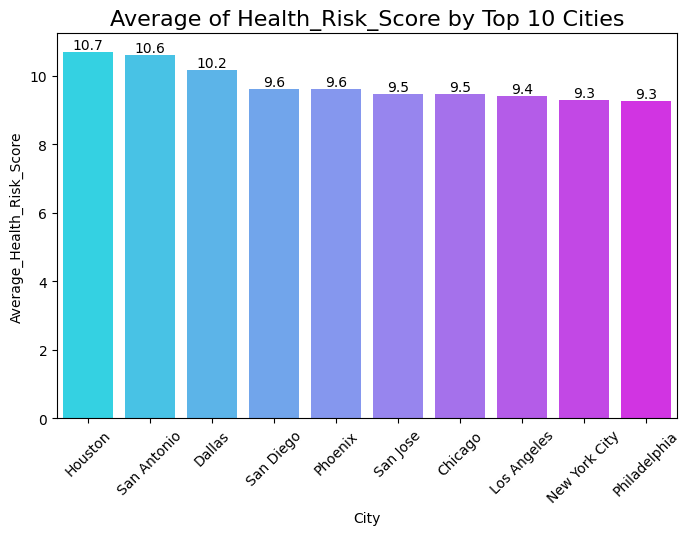

In [16]:
# Group by 'City' and compute the average 'Health_Risk_Score'
df_cat = df_cleaned.groupBy('City').agg(F.mean('Health_Risk_Score').alias('Average_Health_Risk_Score'))

# Sort the DataFrame by the average score and get the top 10 cities
df_cat = df_cat.orderBy(F.desc('Average_Health_Risk_Score')).limit(10)

# Convert to Pandas for plotting
df_cat_pandas = df_cat.toPandas()

# Create the bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='City', y='Average_Health_Risk_Score', data=df_cat_pandas, palette='cool')
plt.title("Average of Health_Risk_Score by Top 10 Cities", fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Adding labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', rotation=0, fontsize=10)

plt.show()

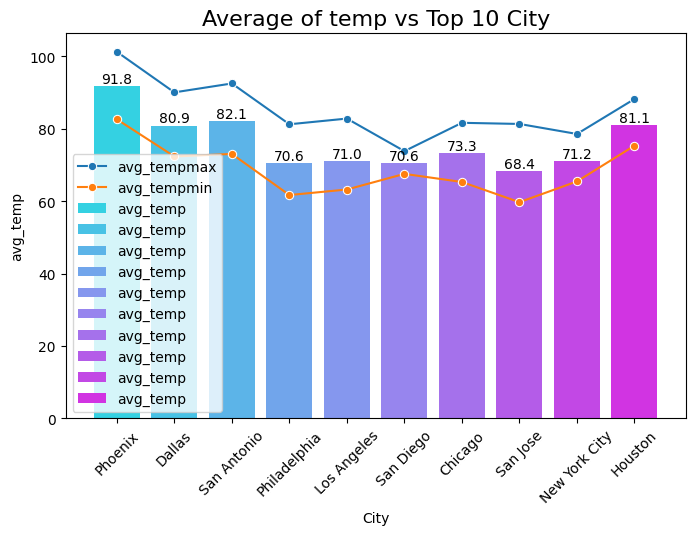

In [17]:
# Group by 'City' and compute the mean of 'tempmin', 'temp', 'tempmax'
df_cat = df_cleaned.groupBy('City').agg(
    F.mean('tempmin').alias('avg_tempmin'),
    F.mean('temp').alias('avg_temp'),
    F.mean('tempmax').alias('avg_tempmax')
)

# Convert to Pandas for plotting
df_cat_pandas = df_cat.toPandas()

# Create the bar and line plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='City', y='avg_temp', data=df_cat_pandas, palette='cool', label='avg_temp')
sns.lineplot(x='City', y='avg_tempmax', data=df_cat_pandas, label='avg_tempmax', marker='o')
sns.lineplot(x='City', y='avg_tempmin', data=df_cat_pandas, label='avg_tempmin', marker='o')

plt.title("Average of temp vs Top 10 City", fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Adding labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', rotation=0, fontsize=10)

plt.legend()
plt.show()

In [18]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# List of categorical columns to be converted
categorical_columns = [col for col, dtype in df_cleaned.dtypes if dtype == 'string']

# Create a list of StringIndexer stages
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Create a pipeline to apply all the indexers
pipeline = Pipeline(stages=indexers)

# Fit and transform the DataFrame
df_indexed = pipeline.fit(df_cleaned).transform(df_cleaned)

# Drop original categorical columns and keep the indexed columns
columns_to_keep = [col + "_index" for col in categorical_columns] + [c for c in df_cleaned.columns if c not in categorical_columns]
df_final = df_indexed.select(columns_to_keep)

# Show the resulting DataFrame
df_final.show(5)


+--------------+-------------------+-------------+-------------+----------+------------------+------------------+---------------+---------+--------------+------------+----------------+-----------------+--------------+---------------+-------------+--------------+----------------+----------------+--------------------+-----------------+-------------+----------------+-------------+------------------+------------+-----------------+---------------+----------------+-----------------+----------+------------+----------+----------------+----------------+--------------------+-----------------+----------------+-----------------------+
|datetime_index|datetimeEpoch_index|tempmax_index|tempmin_index|temp_index|feelslikemax_index|feelslikemin_index|feelslike_index|dew_index|humidity_index|precip_index|precipprob_index|precipcover_index|windgust_index|windspeed_index|winddir_index|pressure_index|cloudcover_index|visibility_index|solarradiation_index|solarenergy_index|uvindex_index|severerisk_index|sun

In [19]:
df_numeric = df_final
# Print column names to verify
print(df_numeric.columns)


['datetime_index', 'datetimeEpoch_index', 'tempmax_index', 'tempmin_index', 'temp_index', 'feelslikemax_index', 'feelslikemin_index', 'feelslike_index', 'dew_index', 'humidity_index', 'precip_index', 'precipprob_index', 'precipcover_index', 'windgust_index', 'windspeed_index', 'winddir_index', 'pressure_index', 'cloudcover_index', 'visibility_index', 'solarradiation_index', 'solarenergy_index', 'uvindex_index', 'severerisk_index', 'sunrise_index', 'sunriseEpoch_index', 'sunset_index', 'sunsetEpoch_index', 'moonphase_index', 'conditions_index', 'description_index', 'icon_index', 'source_index', 'City_index', 'Temp_Range_index', 'Heat_Index_index', 'Severity_Score_index', 'Day_of_Week_index', 'Is_Weekend_index', 'Health_Risk_Score_index']


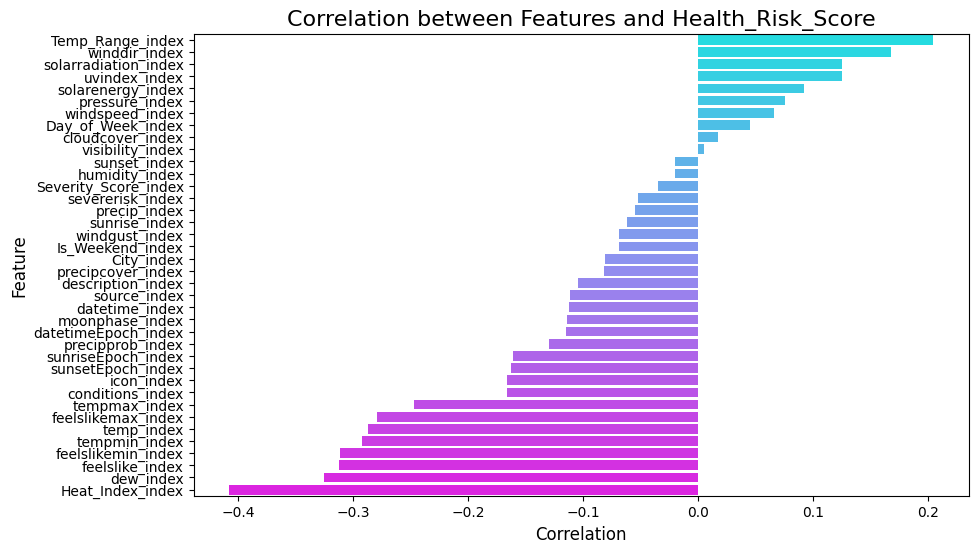

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Ensure that 'Health_Risk_Score_index' is included in the numeric DataFrame
# Use VectorAssembler to create a features column
vector_col = 'features'
assembler = VectorAssembler(inputCols=df_numeric.columns, outputCol=vector_col)
df_vector = assembler.transform(df_numeric)

# Compute the correlation matrix
matrix = Correlation.corr(df_vector, vector_col).head()[0]

# Convert the matrix to a DataFrame
corr_matrix = matrix.toArray()
corr_df = pd.DataFrame(corr_matrix, columns=df_numeric.columns, index=df_numeric.columns)

# Extract correlations with 'Health_Risk_Score_index'
if 'Health_Risk_Score_index' in corr_df.columns:
    corr_with_target = corr_df['Health_Risk_Score_index'].drop('Health_Risk_Score_index').sort_values(ascending=False)
    labels = corr_with_target.index
    corr_values = corr_with_target.values

    # Plot the correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x=corr_values, y=labels, palette='cool')
    plt.title('Correlation between Features and Health_Risk_Score', fontsize=16)
    plt.xlabel('Correlation', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()
else:
    print("The column 'Health_Risk_Score_index' is not present in the correlation matrix.")


In [21]:
# from pyspark.ml.feature import VectorAssembler, MinMaxScaler
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.functions import col

# # Step 1: Prepare data for modeling
# # Remove the target column ('Health_Risk_Score_index') from features
# feature_columns = df_final.columns
# feature_columns.remove('Health_Risk_Score_index')  # Target column for prediction

# # Step 2: Assemble features into a single vector
# assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
# df_assembled = assembler.transform(df_final)

# # Step 3: Scale the features
# scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
# df_scaled = scaler.fit(df_assembled).transform(df_assembled)

# # Update the 'features' column with the scaled features
# df_model = df_scaled.withColumn('features', col('scaled_features')).drop('scaled_features')

# # Step 4: Split the data into training and testing sets
# train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)

# # Step 5: Define the Linear Regression model
# lr = LinearRegression(featuresCol='features', labelCol='Health_Risk_Score_index')

# # Step 6: Train the model
# lr_model = lr.fit(train_df)

# # Step 7: Make predictions on the test data
# predictions = lr_model.transform(test_df)

# # Step 8: Evaluate the model
# evaluator_rmse = RegressionEvaluator(labelCol="Health_Risk_Score_index", predictionCol="prediction", metricName="rmse")
# rmse = evaluator_rmse.evaluate(predictions)

# evaluator_r2 = RegressionEvaluator(labelCol="Health_Risk_Score_index", predictionCol="prediction", metricName="r2")
# r2 = evaluator_r2.evaluate(predictions)

# # Step 9: Print the evaluation results
# print(f"Root Mean Squared Error (RMSE): {rmse}")
# print(f"R-squared: {r2}")

# # Step 10: Show predictions
# predictions.select('Health_Risk_Score_index', 'prediction', 'features').show(5)

# # Step 11: Print model summary
# training_summary = lr_model.summary
# print(f"R-squared on Training Set: {training_summary.r2}")


Root Mean Squared Error (RMSE): 231.7758956244191
R-squared: 0.37293967225018154
+-----------------------+------------------+--------------------+
|Health_Risk_Score_index|        prediction|            features|
+-----------------------+------------------+--------------------+
|                  284.0| 207.6742960027076|[0.0,0.0156599552...|
|                  844.0| 923.0236005607486|[0.0,0.0167785234...|
|                  611.0| 673.5984936991164|[0.0,0.0413870246...|
|                  313.0|  437.858662633667|[0.0,0.4865771812...|
|                  389.0|444.69281029166905|[0.0,0.5055928411...|
+-----------------------+------------------+--------------------+
only showing top 5 rows

RMSE on Training Set: 225.65730391702914
R-squared on Training Set: 0.3832796422517518


In [22]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col

# Step 1: Prepare data for modeling
# Remove the target column ('Health_Risk_Score_index') from features
feature_columns = df_final.columns
feature_columns.remove('Health_Risk_Score_index')  # Target column for prediction

# Step 2: Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df_final)

# Step 3: Scale the features
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

# Update the 'features' column with the scaled features
df_model = df_scaled.withColumn('features', col('scaled_features')).drop('scaled_features')

# Step 4: Split the data into training and testing sets
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)

# Step 5: Define the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='Health_Risk_Score_index')

# Step 6: Set up parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Step 7: Cross-Validation setup
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="Health_Risk_Score_index", metricName="rmse"),
                          numFolds=5)  # 5-fold cross-validation

# Step 8: Fit the model using cross-validation
cv_model = crossval.fit(train_df)

# Step 9: Make predictions on the test data using the best model
predictions = cv_model.bestModel.transform(test_df)

# Step 10: Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="Health_Risk_Score_index", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="Health_Risk_Score_index", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

# Step 11: Print the evaluation results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

# Step 12: Show predictions
predictions.select('Health_Risk_Score_index', 'prediction', 'features').show(5)

# Step 13: Print the best hyperparameters
best_model = cv_model.bestModel
print(f"Best RegParam: {best_model._java_obj.getRegParam()}")
print(f"Best ElasticNetParam: {best_model._java_obj.getElasticNetParam()}")


Root Mean Squared Error (RMSE): 231.141909908613
R-squared: 0.3763654260483389
+-----------------------+------------------+--------------------+
|Health_Risk_Score_index|        prediction|            features|
+-----------------------+------------------+--------------------+
|                  284.0|213.03031726550057|[0.0,0.0156599552...|
|                  844.0| 911.3641358039794|[0.0,0.0167785234...|
|                  611.0| 665.5339577882864|[0.0,0.0413870246...|
|                  313.0| 440.8902959665478|[0.0,0.4865771812...|
|                  389.0| 450.6564705879291|[0.0,0.5055928411...|
+-----------------------+------------------+--------------------+
only showing top 5 rows

Best RegParam: 0.5
Best ElasticNetParam: 1.0
